In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import signal
from scipy.fftpack import fft, fftfreq
from scipy.io import loadmat
import xlsxwriter 
%matplotlib inline
import import_ipynb
import functions_NGD
import random

importing Jupyter notebook from functions_NGD.ipynb


## Load data / find cross-correlation of ganglion cell output

In [2]:
# dt=0.01
# path_spike='F:/我的雲端硬碟/Retina exp/exp data/Sorted_final_data/20200419/'
# file_set=[['OU_tau=100ms_19-Apr-2020_0_sort_unit1.mat',\
#     'OU_tau=100ms_cutoff=10_19-Apr-2020_0_sort_unit1.mat',\
#     'OU_tau=100ms_cutoff=7_19-Apr-2020_0_sort_unit1.mat',\
#     'OU_tau=100ms_cutoff=4_19-Apr-2020_0_sort_unit1.mat',\
#     'OU_tau=100ms_cutoff=2_19-Apr-2020_0_sort_unit1.mat'],\
#     ['OU_tau=600ms_19-Apr-2020_0_sort_unit1.mat',\
#     'OU_tau=600ms_cutoff=10_19-Apr-2020_0_sort_unit1.mat',\
#     'OU_tau=600ms_cutoff=7_19-Apr-2020_0_sort_unit1.mat',\
#     'OU_tau=600ms_cutoff=4_19-Apr-2020_0_sort_unit1.mat',\
#     'OU_tau=600ms_cutoff=2_19-Apr-2020_0_sort_unit1.mat'],\
#     ['OU_tau=1000ms_19-Apr-2020_0_sort_unit1.mat',\
#     'OU_tau=1000ms_cutoff=10_19-Apr-2020_0_sort_unit1.mat',\
#     'OU_tau=1000ms_cutoff=7_19-Apr-2020_0_sort_unit1.mat',\
#     'OU_tau=1000ms_cutoff=4_19-Apr-2020_0_sort_unit1.mat',\
#     'OU_tau=1000ms_cutoff=2_19-Apr-2020_0_sort_unit1.mat']]

# # path_spike='F:/我的雲端硬碟/Retina exp/exp data/Sorted_final_data/20200318/'
# # file1='20200318_OU_tau=op5_fc=10_2_sort_unit1.mat'

# BinSpikes_set=[[[] for k in range(np.size(file_set,1))] for l in range(np.size(file_set,0))]
# sti_set=[[[] for k in range(np.size(file_set,1))] for l in range(np.size(file_set,0))]
# for i in range(np.size(file_set,0)):
#     for j in range(np.size(file_set,1)):
#         data1=loadmat(path_spike+file_set[i][j])
#         spikes=data1['Spikes'][0][38][0]
#         timestamp=data1['TimeStamps'][0]

#         adata1=data1['a_data'][0]
#         t=np.arange(1,len(adata1)+1e-5)/20000
#         sti=adata1[(t>timestamp[0]) & (t<timestamp[1])][0:-1:200]
#         sti=sti-np.mean(sti)
#         sti_set[i][j]=sti/np.std(sti)

#         spikes1=spikes[(spikes>timestamp[0]) & (spikes<timestamp[1])]-timestamp[0]
#         BinningTime=np.arange(0,timestamp[1]-timestamp[0],dt)
#         BinSpikes_set[i][j], bin_edges=np.histogram(spikes1,bins=BinningTime)

## OU generating for simulation 

(200, 210)

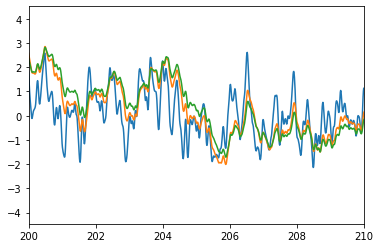

In [3]:
# generate OU input (different tau and different cutoff frequency)
tau_set=[0.1,0.6,1] 
fc=['no',10,7,4,2]
dt=0.01
Tot=300
T=np.arange(dt,Tot,dt)
mu, sigma = 0, 1
ran_seed=np.random.normal(mu,sigma,len(T))
x_set=[[functions_NGD.OU(Tot,tau_set[j],fc[i],dt,ran_seed) for i in range(len(fc))] for j in range(len(tau_set))]
for i in range(len(tau_set)):
    for j in range(len(fc)):
        x_set[i][j]=x_set[i][j]/np.std(x_set[i][j])

for i in range(len(tau_set)):
    plt.plot(T,x_set[i][1])
plt.xlim(200,210)

In [4]:
# real stimulus data as input of simulation
# x_set=[[sti_set[i][j]/np.std(sti_set[i][j]) for j in range(np.size(sti_set,1))] for i in range(np.size(sti_set,0))]
# x_set=sti_set

## NGD output

In [5]:
alpha,beta,K,g=6,1.6,22,10 # channel 39
# alpha,beta,K,g=8,1.4,37,10 # channel 47
y_set=[[functions_NGD.NGD(x_set[i][j],dt,alpha,beta,K,g,1)[0] for j in range(np.size(x_set,1))] for i in range(np.size(x_set,0))]
z_set=[[functions_NGD.NGD(x_set[i][j],dt,alpha,beta,K,g,1)[1] for j in range(np.size(x_set,1))] for i in range(np.size(x_set,0))]

## cross correlation of inputs and outputs

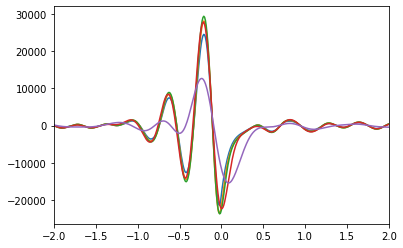

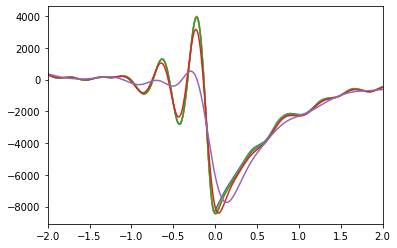

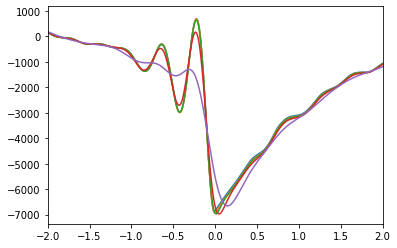

In [6]:
window_size=5
corr_set_sim=[[[] for j in range(np.size(x_set,1))] for i in range(np.size(x_set,0))]
for i in range(np.size(x_set,0)):
    for j in range(np.size(x_set,1)):
        timelag_sim,corr_set_sim[i][j]=functions_NGD.xcorr_quick(x_set[i][j],y_set[i][j],window_size,dt)
        
for j in range(np.size(x_set,0)):
    for i in range(np.size(x_set,1)):    
        plt.plot(timelag_sim,-corr_set_sim[j][i])
    plt.xlim(-2,2)
    plt.show()

## cross correlation of experiment data

In [7]:
window_size=5
corr_set_exp=[[[] for j in range(np.size(sti_set,1))] for i in range(np.size(sti_set,0))]
for i in range(np.size(sti_set,0)):
    for j in range(np.size(sti_set,1)):
        timelag_exp,corr_set_exp[i][j]=functions_NGD.xcorr_quick(sti_set[i][j][:-1],BinSpikes_set[i][j],window_size,dt)

for j in range(np.size(sti_set,0)):
    for i in range(np.size(sti_set,1)):
        plt.plot(timelag_exp,corr_set_exp[j][i])
    plt.xlim(-3,3)
    plt.show()

NameError: name 'sti_set' is not defined

## STA analysis

In [ ]:
STAwindow=5
STA_set=[[[] for i in range(np.size(sti_set,1))] for j in range(np.size(sti_set,0))]
for ntau in range(np.size(sti_set,0)):
    for nfc in range(np.size(sti_set,1)):
        sss=np.zeros(int(1+STAwindow/dt*2))
        n_spikes=0
        for i in range(len(BinSpikes_set[ntau][nfc])):
            if BinSpikes_set[ntau][nfc][i]>0:
                if (i-int(STAwindow/dt)>0) & (i+int(STAwindow/dt)<len(BinSpikes_set[ntau][nfc])-1):
                    n_spikes+=BinSpikes_set[ntau][nfc][i]
                    sss+=BinSpikes_set[ntau][nfc][i]*sti_set[ntau][nfc][i-int(STAwindow/dt):i+int(STAwindow/dt)+1]
        STA_set[ntau][nfc]=sss/n_spikes
t2s=np.arange(-5,5+1e-5,dt)

for j in range(np.size(sti_set,0)):
    for i in range(np.size(sti_set,1)):
        plt.plot(t2s,STA_set[j][i])
    plt.xlim()
    plt.show()

## calculate MI

In [ ]:
# experiment
MI_expset=[[[] for j in range(np.size(sti_set,1))] for i in range(np.size(sti_set,0))]
f1,ax1=plt.subplots(1,3,figsize=(15,4))
for i in range(np.size(sti_set,0)):
    for j in range(np.size(sti_set,1)):
        TS_exp,MI_expset[i][j]=functions_NGD.MI(functions_NGD.EqualState(sti_set[i][j][:-1],8),\
                                                BinSpikes_set[i][j]+1,dt,[-5,5])
        ax1[i].plot(TS_exp,MI_expset[i][j])
    ax1[i].set_xlim(-1,1)
    ax1[i].grid(axis='x')
plt.show()
# simulation
MI_simset=[[[] for j in range(np.size(sti_set,1))] for i in range(np.size(sti_set,0))]
f2,ax2=plt.subplots(1,3,figsize=(15,4))
for i in range(np.size(x_set,0)):
    for j in range(np.size(x_set,1)):
        TS_sim,MI_simset[i][j]=functions_NGD.MI(functions_NGD.EqualState(x_set[i][j],8),\
                                                functions_NGD.EqualState(y_set[i][j],8),dt,[-5,5])
        ax2[i].plot(TS_sim,MI_simset[i][j])
    ax2[i].set_xlim(-1,1)
    ax2[i].grid(axis='x')

In [ ]:
# plot 3 fc
plt.plot(TS_exp,MI_expset[1][0])
plt.plot(TS_exp,MI_expset[1][3])
plt.plot(TS_exp,MI_expset[1][4])
plt.xlim(-1,1)
plt.legend(('no cutoff','$f_c=2 Hz$','$f_c=1 Hz$'))
plt.ylabel('MI (bits/s)')
plt.xlabel('$\delta$t (s)')
plt.axvline(x=0,c='k',linewidth=0.5,linestyle='dashed')

plt.savefig('F:/我的雲端硬碟/Retina exp/Poster present/Sfn poster 20210111/figure/MI_Ptype.png',dpi=300)

In [ ]:
# replot the paper figure
f3,ax3=plt.subplots(2,2,figsize=(10,8))
f3.tight_layout()
for i in range(2):
    for j in range(np.size(MI_expset,1)-1):
        ax3[0][i].plot(TS_exp,MI_expset[i][j])
        ax3[0][i].set_xlim(-1,1)
    ax3[0][i].grid(axis='x',ls='--')
ax3[0][0].set_ylabel('MI (bit/s)',fontsize=14)
for i in range(2):
    for j in range(np.size(MI_simset,1)-1):
        ax3[1][i].plot(TS_sim,MI_simset[i][j])
        ax3[1][i].set_xlim(-1,1)
    ax3[1][i].grid(axis='x',ls='--')
ax3[1][0].set_ylabel('MI (bit/s)',fontsize=14)
ax3[1][0].set_xlabel('$\delta t$ (s)',fontsize=14)
ax3[1][1].set_xlabel('$\delta t$ (s)',fontsize=14)
plt.gcf().subplots_adjust(left=0.15,bottom=0.15)

corner_labels=['A', 'B', 'C', 'D']
n=0

labels=[['a','b'],['c','d']]
for i in range(2):
    for j in range(2):
        ax3[i][j].text(0.07, 0.96, labels[i][j], transform=ax3[i][j].transAxes,fontsize=20, fontweight='bold', va='top', ha='right')        

ax3[0][1].legend(('no filter','$f_c=10Hz$','$f_c=7Hz$','$f_c=4Hz$'))
# f3.savefig('F:/我的雲端硬碟/Retina exp/Retina as NGD paper submit/figure 20201019 modification/MI_figures_with_caption.png')

In [ ]:
c=['r','b','k','g','y']
ls=['-','--']
for i in range(2):
    for j in range(np.size(sti_set,1)):
        plt.plot(TS_exp,MI_expset[i][j],color=c[j],linestyle=ls[i])
plt.xlim(-1,1)

### find MI peak position

In [ ]:
# find MI peak positions from experiment data
sym=['o','*','+']
fc=np.array([float('inf'),10,7,4,2])
TSpeak_exp=[np.zeros(np.size(MI_expset,1)) for i in range(np.size(MI_expset,0))]
for n in range(np.size(MI_expset,0)):
    for i in range(np.size(MI_expset,1)):
        loc2=np.argmax(MI_expset[n][i][TS_exp>-0.1])
        TSpeak_exp[n][i]=TS_exp[TS_exp>-0.1][loc2]
    plt.plot(fc,TSpeak_exp[n],sym[n])
plt.legend((r'$\tau$=100ms',r'$\tau$=600ms',r'$\tau$=1000ms'))
plt.show()
# find MI peak positions from simulation data
sym=['o','*','+']
fc=np.array([float('inf'),10,7,4,2])
TSpeak_sim=[np.zeros(np.size(MI_simset,1)) for i in range(np.size(MI_simset,0))]
for n in range(np.size(MI_simset,0)):
    for i in range(np.size(MI_simset,1)):
        loc2=np.argmax(MI_simset[n][i][TS_sim>-0.1])
        TSpeak_sim[n][i]=TS_sim[TS_sim>-0.1][loc2]
    plt.plot(fc,TSpeak_sim[n],sym[n])
plt.legend((r'$\tau$=100ms',r'$\tau$=600ms',r'$\tau$=1000ms'))

In [ ]:
f,ax=plt.subplots(figsize=(8,6))
# ax=f.add_axes()
sym=['o','*','+']
for n in range(np.size(MI_expset,0)):
    ax.scatter(fc,TSpeak_exp[n],marker=sym[n],s=100)
    ax.grid()
    ax.set_ylabel('MI peak timelag (s)',fontsize=18)
    ax.set_xlabel('OU cut-off frequency (hz)',fontsize=18)
    ax.tick_params(labelsize=12)
#     ax.set_title('Experiment')
ax_inset=ax.inset_axes([0.5, 0.57, 0.35, 0.35])
for n in range(np.size(MI_simset,0)):
    ax_inset.plot(fc,TSpeak_sim[n],sym[n])
#     ax_inset.set_title('Simulation',fontsize=12)
#     ax_inset.grid()

plt.savefig('F:/我的雲端硬碟/Retina exp/Retina as NGD paper submit/figure 20201015/MIpeak_timelag.png')

### save MI peak position data

In [ ]:
workbook = xlsxwriter.Workbook('F:/我的雲端硬碟/Retina exp/Retina as NGD paper submit/figure 20201019 modification/MIpeak_position_exp.xlsx') 
worksheet = workbook.add_worksheet()
for n in range(len(fc)-1):
    worksheet.write(n,0,fc[n+1])
row=0
for i in range(len(TSpeak_exp)):
    row+=1
    for n in range(len(TSpeak_exp[i])-1):
        worksheet.write(n,row,TSpeak_exp[i][n+1])
workbook.close()

In [ ]:
workbook = xlsxwriter.Workbook('F:/我的雲端硬碟/Retina exp/Retina as NGD paper submit/figure 20201019 modification/MIpeak_position_sim.xlsx') 
worksheet = workbook.add_worksheet()
for n in range(len(fc)-1):
    worksheet.write(n,0,fc[n+1])
row=0
for i in range(len(TSpeak_sim)):
    row+=1
    for n in range(len(TSpeak_sim[i])-1):
        worksheet.write(n,row,TSpeak_sim[i][n+1])
workbook.close()

## poisson generation

In [ ]:
SpikeTrains_Poisson=[[[] for i in range(np.size(y_set,1))] for j in range(np.size(y_set,0))]
thr=0.6
for i in range(np.size(y_set,0)):
    for j in range(np.size(y_set,1)):
        rtemp=y_set[i][j]-thr
        rtemp[rtemp>0]=0
        rtemp=rtemp/np.mean(rtemp)*5 # let the mean firing rate as 5 hz
        tempspikes=np.zeros(len(rtemp))
        for step in range(len(rtemp)):
            if random.random()<rtemp[step]*dt:
                tempspikes[step]=1
            else:
                tempspikes[step]=0
        SpikeTrains_Poisson[i][j]=tempspikes

## poisson spikes STA

In [ ]:
STAwindow=5
PoissonSTA_set=[[[] for i in range(np.size(x_set,1))] for j in range(np.size(x_set,0))]
for ntau in range(np.size(x_set,0)):
    for nfc in range(np.size(x_set,1)):
        sss=np.zeros(int(1+STAwindow/dt*2))
        n_spikes=0
        for i in range(len(SpikeTrains_Poisson[ntau][nfc])):
            if SpikeTrains_Poisson[ntau][nfc][i]>0:
                if (i-int(STAwindow/dt)>0) & (i+int(STAwindow/dt)<len(SpikeTrains_Poisson[ntau][nfc])-1):
                    n_spikes+=SpikeTrains_Poisson[ntau][nfc][i]
                    sss+=SpikeTrains_Poisson[ntau][nfc][i]*x_set[ntau][nfc][i-int(STAwindow/dt):i+int(STAwindow/dt)+1]
        PoissonSTA_set[ntau][nfc]=sss/n_spikes
t2s=np.arange(-5,5+1e-5,dt)

for j in range(np.size(x_set,0)):
    for i in range(np.size(x_set,1)):
        plt.plot(t2s,PoissonSTA_set[j][i])
    plt.xlim(-2,2)
    plt.show()

In [ ]:
figSTA ,axSTA=plt.subplots(2,3,figsize=(15,8))
figSTA.tight_layout()
for i in range(np.size(PoissonSTA_set,0)):
    for j in range(np.size(PoissonSTA_set,1)):
        axSTA[0][i].plot(t2s,PoissonSTA_set[i][j])
    axSTA[0][i].set_xlim(-1,1)
    axSTA[0][i].grid(axis='x',ls='--')
for i in range(np.size(STA_set,0)):
    for j in range(np.size(STA_set,1)):
        axSTA[1][i].plot(t2s,STA_set[i][j])
    axSTA[1][i].set_xlim(-1,1)
    axSTA[1][i].grid(axis='x',ls='--')
plt.gcf().subplots_adjust(left=0.15,bottom=0.15)

In [ ]:
# # output simualtion STA
# workbook = xlsxwriter.Workbook('F:/我的雲端硬碟/Retina exp/Retina as NGD paper submit/figure 20201015/sim_STA.xlsx') 
# worksheet = workbook.add_worksheet()
# for n in range(len(t2s)):
#     worksheet.write(n,0,t2s[n]*1000)
# row=0
# for i in range(np.size(PoissonSTA_set,0)):
#     for j in range(np.size(PoissonSTA_set,1)):
#         row+=1
#         for n in range(len(PoissonSTA_set[i][j])):
#             worksheet.write(n,row,PoissonSTA_set[i][j][n])
# workbook.close()

In [ ]:
# # output experiment STA
# workbook = xlsxwriter.Workbook('F:/我的雲端硬碟/Retina exp/Retina as NGD paper submit/figure 20201015/EXP_STA_CH39.xlsx') 
# worksheet = workbook.add_worksheet()
# for n in range(len(t2s)):
#     worksheet.write(n,0,t2s[n]*1000)
# row=0
# for i in range(np.size(STA_set,0)):
#     for j in range(np.size(STA_set,1)):
#         row+=1
#         for n in range(len(STA_set[i][j])):
#             worksheet.write(n,row,STA_set[i][j][n])
# workbook.close()

## Plot P cell

In [ ]:
# channel 39
fP,axP=plt.subplots(2,1,figsize=(8,6))
fP.tight_layout()
for i in range(np.size(MI_expset,1)):
    axP[0].plot(TS_exp,MI_expset[0][i],linewidth=2)
axP[0].set_xlim(-1,1)
axP[0].grid(axis='x',ls='--')
labels = [item.get_text() for item in ax.get_xticklabels()]
empty_string_labels = ['']*len(labels)
axP[0].set_xticklabels(empty_string_labels)
axP[0].set_ylabel('MI (bits/s)',fontsize=15)
for i in range(np.size(STA_set,1)):
    axP[1].plot(t2s,STA_set[0][i])
axP[1].set_xlim(-1,1)
axP[1].grid(axis='x',ls='--')
axP[1].set_ylabel('$h(t)$',fontsize=15)
axP[1].set_xlabel('$\delta t$ (s)',fontsize=15)

axP[0].legend(('no filter','$f_c=10Hz$','$f_c=7Hz$','$f_c=4Hz$','$f_c=2Hz$'))

plt.gcf().subplots_adjust(left=0.15,bottom=0.15)
# plt.savefig('F:/我的雲端硬碟/Retina exp/Retina as NGD paper submit/figure 20201019 modification/sub_fig1 P.png')

## load and plot N type cell

In [ ]:
BinSpikesN_set=[[[] for i in range(np.size(file_set,1))] for j in range(np.size(file_set,0))]
MI_N_expset=[[[] for i in range(np.size(file_set,1))] for j in range(np.size(file_set,0))]
for i in range(np.size(file_set,0)):
    for j in range(np.size(file_set,1)):
        data1=loadmat(path_spike+file_set[i][j])
        spikes_N=data1['Spikes'][0][31][0]
        timestamp=data1['TimeStamps'][0]
        adata1=data1['a_data'][0]
        t=np.arange(1,len(adata1)+1e-5)/20000
        sti=adata1[(t>timestamp[0]) & (t<timestamp[1])][0:-1:200]
        sti=sti-np.mean(sti)
        sti_set[i][j]=sti/np.std(sti)
        
        spikes_N1=spikes_N[(spikes_N>timestamp[0]) & (spikes_N<timestamp[1])]-timestamp[0]
        BinningTime=np.arange(0,timestamp[1]-timestamp[0],dt)
        BinSpikesN_set[i][j], bin_edges=np.histogram(spikes_N1,bins=BinningTime)
        TS_exp,MI_N_expset[i][j]=functions_NGD.MI(functions_NGD.EqualState(sti_set[i][j][:-1],8),\
                                                BinSpikesN_set[i][j]+1,dt,[-5,5])       
        

## load and plot Gaussian data

In [ ]:
datapath='F:/我的雲端硬碟/Retina exp/Retina as NGD paper submit/figure 20201019 modification/'
fileGaussian=['gaussianOFF.mat','gaussianON.mat']
data1=loadmat(datapath+fileGaussian[0])
data2=loadmat(datapath+fileGaussian[1])
fr1=data1['frN'][0]
fr2=data2['frN'][0]
tspike1=data1['tBinning'][0]
tspike2=data2['tBinning'][0]
tsti1=data1['tSingleSti'][0]
tsti2=data2['tSingleSti'][0]
sti1=data1['SingleSti']
sti2=data2['SingleSti']

In [ ]:
f_Gaussian,ax_sti=plt.subplots(figsize=(8,6))
ax_sti.plot(tsti1-1,sti1,color='r')
ax_sti.plot(tsti2-1,sti2,color='b')
ax_sti.set_ylim(-5,16)
ax_Gaussian=ax_sti.twinx()
ax_Gaussian.fill(tspike1-1,fr1,color='r')
ax_Gaussian.fill(tspike2-1,fr2,color='b')
ax_Gaussian.set_xlim(0,4)
ax_Gaussian.set_ylim(0,150)
ax_sti.set_ylabel('light intensity ($mW/m^2$)',fontsize=16)
ax_Gaussian.set_ylabel('firing rate (Hz)',fontsize=16)
ax_sti.set_xlabel('time (s)',fontsize=16)

plt.savefig('F:/我的雲端硬碟/Retina exp/Retina as NGD paper submit/revised figure 20201104/supfig/Gaussian N type.png',dpi=300)

## adding horizontal cell feedfoward pathway

In [ ]:
wy=np.linspace(0.8,1,9)
print(wy)
# wy=[]
itau=2
ifc=2
x=x_set[itau][ifc]
y=y_set[itau][ifc]
z=z_set[itau][ifc]
B=[wy[k]*y-(1-wy[k])*z for k in range(len(wy))]
MIxyz=[[] for i in range(len(B))]
corrxyz=[[] for i in range(len(B))]
for k in range(len(B)):
    tsxyz,MIxyz[k]=functions_NGD.MI(functions_NGD.EqualState(x,8),functions_NGD.EqualState(B[k],8),dt,[-2,2])
    tc,corrxyz[k]=functions_NGD.xcorr_quick(x,B[k],1,0.01)
for i in range(len(B)):
    plt.plot(tsxyz,MIxyz[i],label='w='+str(round(wy[i],3)))
plt.legend()
plt.xlim(-1,1)
plt.ylabel('MI')
plt.xlabel('$\delta t$ (s)')
plt.grid()
# find prediction horizon

for i in range(len(MIxyz)):
    plt.plot(tsxyz[np.argmax(MIxyz[i])],max(MIxyz[i]),'o')
plt.show()
    
# plt.savefig('F:/我的雲端硬碟/Retina exp/exp data/整理/figures/MI_fb_ff.png',dpi=300)

for i in range(len(B)):
    plt.plot(tc,corrxyz[i])
plt.xlim(-1,1)
plt.grid()

In [ ]:
wy_set=np.linspace(0.8,0.9,5)
for nw in range(len(wy_set)):
    wy=wy_set[nw]
    itau=2
    B_fc=[wy*y_set[itau][ifc]-(1-wy)*z_set[itau][ifc] for ifc in range(np.size(x_set,1))]
    MIxyz_fc=[[] for i in range(len(B_fc))]
    for k in range(len(B_fc)):
        tsxyz,MIxyz_fc[k]=functions_NGD.MI(functions_NGD.EqualState(x_set[itau][k],8),functions_NGD.EqualState(B_fc[k],8),dt,[-1,1])
    plt.figure()
    for i in range(len(B_fc)):
        plt.plot(tsxyz,MIxyz_fc[i])
    plt.xlim(-1,1)
    plt.grid()

In [ ]:
functions_NGD.xcorr_quick